In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

Node = Tuple[int, int]

In [3]:
def manhattan_distance(node1: Node, node2: Node) -> float:
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])


class LatticeDistance:

    def __init__(self, n: int) -> None:
        self.n = n

    def __call__(self, node1: Node, node2: Node) -> float:
        dx = abs(node1[0] - node2[0])
        dy = abs(node1[1] - node2[1])
        if dx > self.n / 2:
            dx = self.n - dx
        if dy > self.n / 2:
            dy = self.n - dy
        return dx + dy

def euclidean_distance(node1: Node, node2: Node) -> float:
    return ((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)**0.5

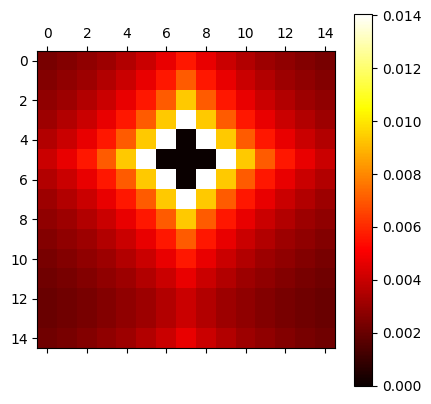

In [4]:
def offset_proba_mtx(n: int, node: Node, alpha: float) -> np.ndarray:
    mtx = np.zeros((n, n))
    ld = LatticeDistance(n)
    for i in range(n):
        for j in range(n):
            if ld(node, (i, j)) < 2:
                continue
            mtx[i, j] = ld(node, (i, j))**-alpha
    mtx /= mtx.sum()
    return mtx


ALPHA = 1

N = 15
m = offset_proba_mtx(N, (5, 7), ALPHA)
plt.matshow(m, cmap='hot')
plt.colorbar()

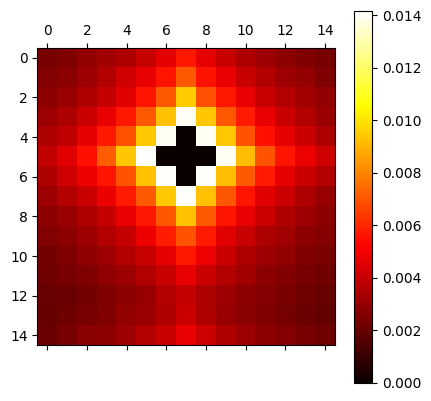

In [5]:
N_SAMPLES = 1000000
probas = m.reshape(-1)
samples = np.random.choice(np.arange(N**2), size=N_SAMPLES, p=probas)
x = samples // N
y = samples % N
empirical = np.zeros((N, N))
for i in range(N_SAMPLES):
    empirical[x[i], y[i]] += 1
empirical /= empirical.sum()
plt.matshow(empirical, cmap='hot')
plt.colorbar()

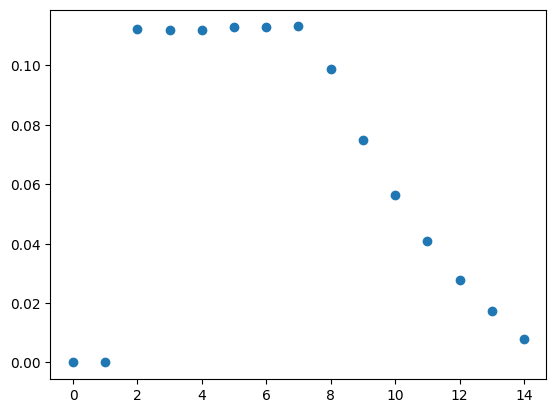

In [6]:
ld = LatticeDistance(N)
empirical_distances = {}
for i in range(N):
    for j in range(N):
        dist = ld((5, 7), (i, j))
        if dist not in empirical_distances:
            empirical_distances[dist] = 0
        empirical_distances[dist] += empirical[i, j]
plt.scatter(empirical_distances.keys(), empirical_distances.values())

In [42]:
def num_of_distance(n,i):
    assert n % 2 == 1
    diameter = (n-1) // 2
    if i == 0:
        return 1
    if i <= diameter:
        return 4 * i
    z = 2*diameter - i+1
    return 4 * z

dict(num_occurrences) ==  {k: num_of_distance(N, k) for k in empirical_distances.keys()}

True

Counter({8: 28, 7: 28, 9: 24, 6: 24, 10: 20, 5: 20, 11: 16, 4: 16, 12: 12, 3: 12, 2: 8, 13: 8, 1: 4, 14: 4, 0: 1})


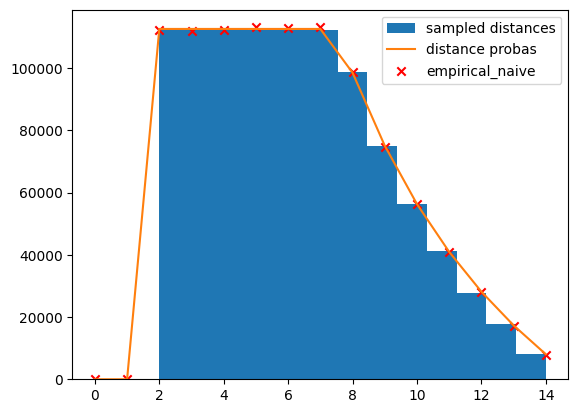

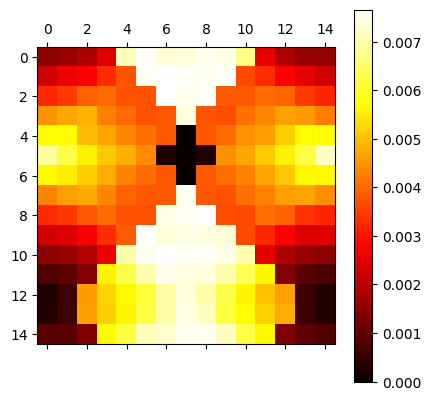

In [36]:
from collections import Counter
# smart sampling
max_dist = 14
distance_probas = np.array([0] + [i**-ALPHA for i in range(1, max_dist+1)])
distance_probas[1] = 0
distance_mtx = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        distance_mtx[i, j] = ld((5, 7), (i, j))

num_occurrences = Counter(distance_mtx.astype(int).flatten())
print(num_occurrences)
for k, v in num_occurrences.items():
    distance_probas[k] *= v
distance_probas /= distance_probas.sum()

distances = np.random.choice(np.arange(len(distance_probas)), size=N_SAMPLES, p=distance_probas)
plt.hist(distances, bins=len(distance_probas)-2, label="sampled distances")
plt.plot(distance_probas * N_SAMPLES, label="distance probas")
plt.scatter(empirical_distances.keys(), np.array(list(empirical_distances.values())) * N_SAMPLES, c="red", marker="x", label="empirical_naive")
plt.legend()
plt.show()

# based on distance, we need to count how many different offsets with that distance we have
# then sample uniformly from those offsets
# TODO: programatically compute these instead of storing them
#num_possible = np.array([num_occurrences[d] for d in distances])
#index = np.random.randint(0, num_possible)

dx = np.random.randint(-N//2+1, N//2+1, size=N_SAMPLES)
dy = distances - np.abs(dx)
x_sign = 1 # np.random.choice([-1, 1], size=N_SAMPLES)
y_sign = np.random.choice([-1, 1], size=N_SAMPLES)
x = (5 + x_sign * dx) % N
y = (7 + y_sign * dy) % N
empirical = np.zeros((N, N))
for i in range(N_SAMPLES):
    empirical[x[i], y[i]] += 1
empirical /= empirical.sum()
plt.matshow(empirical, cmap='hot')
plt.colorbar()

In [30]:
Counter(dx)

Counter({5: 66606,
         -2: 66635,
         -3: 66694,
         -5: 66668,
         -4: 66875,
         4: 66861,
         0: 66584,
         -1: 66771,
         -6: 66661,
         7: 66434,
         1: 66639,
         3: 66816,
         2: 66234,
         -7: 66711,
         6: 66811})

In [31]:
Counter(distances)

Counter({6: 112678,
         9: 75125,
         5: 112750,
         8: 98510,
         3: 112648,
         13: 17089,
         2: 112505,
         4: 112476,
         7: 112604,
         11: 41335,
         12: 28026,
         10: 56294,
         14: 7960})